In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

c:\Users\ammar\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\ammar\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\ammar\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import numpy as np
import torch
import math

class_names = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E',
    5: 'F',
    6: 'G',
    7: 'H',
    8: 'I'
}

transform = transforms.Compose([
            # transforms.RandomHorizontalFlip(), # Flip the data horizontally
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
        ])

# Load the data with all of the classes
data = datasets.ImageFolder(root='../lab3data', transform=None)
data_list = np.array(data.imgs)

# Get the indices for the train/val/test split of 75/15/15
train_split = math.floor(0.7 * len(data))
val_split = math.ceil(0.15 * len(data))
test_split = val_split

# print(train_split + val_split + test_split, len(data_arr))

# Make sure the splits are correct
assert train_split + val_split + test_split == len(data)

# Split the dataset randomely
generator = torch.Generator().manual_seed(1)
train, val, test = torch.utils.data.random_split(data, [train_split, val_split, test_split], generator=generator)


In [3]:
import cv2

class GenData(torch.utils.data.Dataset):
    '''
        Data set class to store the feature maps
    
    '''

    def __init__(self, in_data, transform=None):
        data = np.array(in_data)
        self.input_dirs = data[:, 0]
        self.labels = data[:, 1]
        self.input_transform = transform[0]
        self.transform = transform[1]

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        input_dir = self.input_dirs[idx]

        # Load the data
        inputs = cv2.imread(input_dir)
        inputs = cv2.cvtColor(inputs, cv2.COLOR_BGR2RGB)
        # inputs = inputs.swapaxes(0, 2)

        labels = (int)(self.labels[idx])

        if self.transform:
            inputs = self.input_transform(inputs)
            transformed = self.transform(inputs)

            return inputs, transformed, labels
        else:
            return inputs, inputs, labels

In [4]:
# Create data loaders
def get_data_loaders(batch_size=1):
    
    train_data = GenData(data_list[train.indices], transform=(transform, transform))
    val_data = GenData(data_list[val.indices], transform=(transform, transform))
    test_data = GenData(data_list[test.indices], transform=(transform, transform))

    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

    return train_dataloader, val_dataloader, test_dataloader



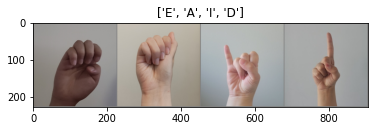

In [5]:
'''Code to visualize the data in the training set'''

import torchvision


def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
train_dataloader, _, _ = get_data_loaders(4)
inputs, _, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x.item()] for x in classes])

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



class VAENet(nn.Module):
    def __init__(self, name="BirdNet"):
        super(VAENet, self).__init__()

        self.name = name

        self.latent_dim = 256

        self.front = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=3), # 224 --> 72 = (224 + 0 - 11)/3 + 1
            nn.MaxPool2d(kernel_size=3, stride=3), # 72 --> 24 = (72 + 0 - 3)/3 + 1
            nn.ReLU(),
            nn.BatchNorm2d(96),

            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=3, padding=1, stride=1), # 24 --> 24 = (24 + 2 - 3)/1 + 1
            nn.MaxPool2d(kernel_size=4, stride=2), # 24 --> 11 (24 + 6 - 3)/3 + 1
            nn.ReLU(),
            nn.BatchNorm2d(256),

            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1, stride=1), # 11 --> 11 = (11 + 2 - 3)/1 + 1
            nn.ReLU(),
            nn.BatchNorm2d(384),

            # nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1, stride=1), # 11 --> 11 = (11 + 2 - 3)/1 + 1
            # nn.ReLU(),
            # nn.BatchNorm2d(384),

            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1), # 11 --> 11 = (10 + 2 - 3)/1 + 1
            nn.MaxPool2d(kernel_size=3, stride=2), # 11 --> 5 = (11 + 0 - 3)/2 + 1
            nn.ReLU(),
            nn.BatchNorm2d(256),

        )

        self.muFC = nn.Linear(5 * 5 * 256, self.latent_dim)
        self.logvarFC = nn.Linear(5 * 5 * 256, self.latent_dim)

        self.latentFC = nn.Linear(self.latent_dim, 5 * 5 * 256)

        self.back = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=384, kernel_size=3, stride=2, padding=0, output_padding=0), # 5 -> 11
            nn.ReLU(),
            nn.BatchNorm2d(384),

            nn.ConvTranspose2d(in_channels=384, out_channels=256, kernel_size=3, padding=0, stride=2, output_padding=1), # 11 -> 24
            nn.ReLU(),
            nn.BatchNorm2d(256),

            nn.ConvTranspose2d(in_channels=256, out_channels=96, kernel_size=3, padding=0, stride=3, output_padding=0), # 24 -> 72
            nn.ReLU(),
            nn.BatchNorm2d(96),

            nn.ConvTranspose2d(in_channels=96, out_channels=3, kernel_size=11, padding=0, stride=3, output_padding=0), # 72 -> 224
            nn.ReLU()
        )

    def encoder(self, x):
        x = self.front(x)
        x = x.view(-1, 5 * 5 * 256)

        mu = self.muFC(x)
        logvar = self.logvarFC(x)

        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = std.data.new(std.size()).normal_()
        return eps.mul(std).add_(mu)
    
    def decoder (self, x):
        x = self.latentFC(x)
        x = x.view(-1, 256, 5, 5)

        x = self.back(x)
        x = F.softmax(x, 0)

        return x

    def forward(self, x):
        # x = self.forward_pass(x)
        # x = x.squeeze(1)
        # x = F.softmax(x, dim=1)

        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        y = self.decoder(z)
        
        return y, z, mu, logvar

In [7]:
# from torchsummary import summary

# model = VAENet()
# model.to('cuda:0')

# summary(model, (3, 224, 224))

In [8]:
'''
Loss function
'''

def vaekl_loss(recon_x, x, mu, logvar, batch_size):
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kld /= batch_size * 3 * 224 * 224
    return kld

In [9]:
'''
Helper functions (based off of previous labs)
'''

def calculate_error(input, target):
    difference = torch.abs(target - input)
    mean_error = torch.mean(difference)

    return mean_error


def evaluate(model, loader, criterion, cuda=False, batch_size=64, alex=False):
    '''
    Function to evaluate the model's performance on a val/test set
    '''


    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, transformed, labels = data

        ########## SENDING TO CUDA ############
        if cuda:
            inputs = inputs.to('cuda:0')
            transformed = transformed.to('cuda:0')
            
        

        outputs, latent_vector, mu, logvar = model(transformed)

        if alex:
            labels = labels.squeeze(1)

        loss = criterion(outputs, inputs.float()) + vaekl_loss(outputs, inputs, mu, logvar, batch_size)

        # Find the mean error over the image
        output_err = calculate_error(outputs, inputs) 

        total_err += output_err
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss


def get_model_name(name, batch_size, learning_rate, momentum, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_m{3}_epoch{4}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   momentum,
                                                   epoch)
    return path


# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()


In [10]:
'''
Train Loop
'''

import tqdm
import time
from torch.optim import lr_scheduler

OUTPUT_DIR = 'runs/'

def train_network(model, batch_size=32, lr=0.005, momentum=0.9, num_epochs=30, cuda=True, loader=None, alex=False, sheduler=False):

    # Set manual seed for reproducible results
    torch.manual_seed(1)

    # Get the dataloaders with respective batch size
    train_dl, val_dl, _ = get_data_loaders(batch_size=batch_size)

    # Criterion and optimizer
    criterion = nn.MSELoss()
    optimizer =  optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    if sheduler:
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

    # optimizer =  optim.Adam(model.parameters(), lr=lr)


    # Training metrics
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    best_train_err = 1000
    best_val_err = 1000

    ########## SENDING TO CUDA ############
    if cuda:
        model = model.to('cuda:0')

    start_time = time.time()
    model.train()

    # Train loop
    for epoch in tqdm.tqdm(range(num_epochs)):
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0

        for i, data in enumerate(train_dl if not loader else loader):

            inputs, transformed, labels = data


            ########## SENDING TO CUDA ############
            if cuda:
                inputs = inputs.to('cuda:0')
                transformed = transformed.to('cuda:0')

            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs, latent_vector, mu, logvar = model(transformed)

            if alex:
                labels = labels.squeeze(1)

            loss = criterion(outputs, inputs.float()) + vaekl_loss(outputs, inputs, mu, logvar, batch_size)
            loss.backward()
            optimizer.step()

            # Find the mean error over the image
            output_err = calculate_error(outputs, inputs)

            total_train_err += output_err
            total_train_loss += loss.item()
            total_epoch += len(labels)

        if sheduler:
            exp_lr_scheduler.step()

        train_err[epoch] = float(total_train_err) / (total_epoch)
        train_loss[epoch] = float(total_train_loss) / (i + 1)
        val_err[epoch], val_loss[epoch] = evaluate(model, val_dl if not loader else loader, criterion, cuda, batch_size, alex)

        tqdm.tqdm.write(f'Epoch {epoch}: Train err: {train_err[epoch]}, Train loss: {train_loss[epoch]} | Validation err: {val_err[epoch]}, Validation loss: {val_loss[epoch]}')

        # Check whether a better train/val err has been found
        better = False
        if train_err[epoch] < best_train_err:
            best_train_err = train_err[epoch]
            better = True
        if val_err[epoch] < best_val_err:
            best_val_err = val_err[epoch]
            better = True

        if better or epoch == (num_epochs - 1):
            model_path = OUTPUT_DIR + get_model_name(model.name, batch_size, lr, momentum, epoch)

            torch.save(model.state_dict(), model_path)

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)



In [11]:
'''
More epochs
'''

net = VAENet("ASL")

batch = 1
lr = 0.005
m = 0.9
epochs = 100

train_network(net, batch_size=batch, lr=lr, momentum=m, num_epochs=epochs)
model_path =  OUTPUT_DIR + get_model_name(net.name, batch, lr, m, epochs-1)
plot_training_curve(model_path)

  1%|          | 1/100 [00:28<47:19, 28.68s/it]

Epoch 0: Train err: 0.772838703064633, Train loss: 0.7193378319355724 | Validation err: 0.7613094662044857, Validation loss: 0.70037069692984


  2%|▏         | 2/100 [01:04<53:21, 32.67s/it]

Epoch 1: Train err: 0.772838703064633, Train loss: 0.7192622040999911 | Validation err: 0.7613094662044857, Validation loss: 0.7003243323023971


  3%|▎         | 3/100 [01:44<58:39, 36.29s/it]

Epoch 2: Train err: 0.772838703064633, Train loss: 0.7192223473798054 | Validation err: 0.7613094662044857, Validation loss: 0.700291634948404


  4%|▍         | 4/100 [02:17<55:49, 34.89s/it]

Epoch 3: Train err: 0.772838703064633, Train loss: 0.7191921799261956 | Validation err: 0.7613094662044857, Validation loss: 0.7002652262424206
